In [1]:
!pip install transformers #installing because we want to use pre_trained models, both from huggingface and our own models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import DebertaForSequenceClassification, RobertaForSequenceClassification
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')
base_dir = '/content/drive/My Drive/ESC324projectdrive/dav/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#function to load pickle files
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

#loading the pickle files
(train_dataloader_roberta, val_dataloader_roberta, test_dataloader_roberta) = load_pickle(base_dir + 'dataloaders_roberta.pickle')
(train_dataloader_deberta, val_dataloader_deberta, test_dataloader_deberta) = load_pickle(base_dir + 'dataloaders_deberta.pickle')

In [5]:
print(len(train_dataloader_roberta))
print(len(val_dataloader_roberta))
print(len(test_dataloader_roberta))

print(len(train_dataloader_deberta))
print(len(val_dataloader_deberta))
print(len(test_dataloader_deberta))

126
27
27
126
27
27


In [6]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

deberta_model = DebertaForSequenceClassification.from_pretrained(base_dir + 'deberta_model_25_epochs')
roberta_model = RobertaForSequenceClassification.from_pretrained(base_dir + 'roberta_model_26_epochs')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
deberta_model.to(device)
roberta_model.to(device)
print(["Using CPU", "Using Cuda"][int(torch.cuda.is_available())])


Using Cuda


In [7]:
#function to calculate accuracy of the model for a given batch of data
def accuracy(model_output, ground_truth_labels, rel_freq_heuristic):
  model_output = model_output.cpu() * rel_freq_heuristic.cpu()
  model_output = torch.argmax(model_output, dim=1)
  model_output = np.array(model_output)
  ground_truth_labels = np.array(ground_truth_labels.detach().cpu())

  #checking how many values in model_output are equal to their corresponding values in ground_truth_labels
  num_correct = np.sum(model_output == ground_truth_labels)
  accuracy_val = num_correct / len(ground_truth_labels)
  return accuracy_val

In [9]:
val_loss = []
val_acc = []

best_acc = 0
best_k = 0

for k in tqdm(np.arange(0, 1.001, 0.001)):
    # Validation loop
    total_val_loss = 0
    total_val_acc = 0
    roberta_model.eval()
    deberta_model.eval()

    for index, (batch_roberta, batch_deberta) in enumerate(zip(val_dataloader_roberta, val_dataloader_deberta)):
        input_ids_roberta, attention_mask_roberta, labels_roberta, rel_freq_heuristic_roberta = batch_roberta
        input_ids_roberta, attention_mask_roberta, labels_roberta, rel_freq_heuristic_roberta = input_ids_roberta.to(device), attention_mask_roberta.to(device), labels_roberta.to(device), rel_freq_heuristic_roberta.to(device)

        input_ids_deberta, attention_mask_deberta, labels_deberta, rel_freq_heuristic_deberta = batch_deberta
        input_ids_deberta, attention_mask_deberta, labels_deberta, rel_freq_heuristic_deberta = input_ids_deberta.to(device), attention_mask_deberta.to(device), labels_deberta.to(device), rel_freq_heuristic_deberta.to(device)

        with torch.no_grad():
            deberta_outputs = deberta_model(input_ids_deberta, attention_mask = attention_mask_deberta, labels = labels_deberta)
            deberta_loss = deberta_outputs[0].item()
            deberta_output_data = deberta_outputs[1].detach().cpu()

            roberta_outputs = roberta_model(input_ids_roberta, attention_mask = attention_mask_roberta, labels = labels_roberta)
            roberta_loss = roberta_outputs[0].item()
            roberta_output_data = roberta_outputs[1].detach().cpu()

            total_val_loss += k * deberta_loss + (1 - k) * roberta_loss
            ensemble_outputs = k * deberta_output_data + (1 - k) * roberta_output_data
            #calculating accuracy for batch
            total_val_acc += accuracy(ensemble_outputs, labels_roberta, rel_freq_heuristic_roberta)
        
        # Delete unnecessary values to save memory
        del input_ids_roberta, attention_mask_roberta, labels_roberta, rel_freq_heuristic_roberta, input_ids_deberta, attention_mask_deberta, labels_deberta, rel_freq_heuristic_deberta, roberta_outputs, deberta_outputs, roberta_loss, deberta_loss

    # Calculate average validation loss
    avg_val_loss = total_val_loss / len(val_dataloader_deberta)
    avg_val_acc = total_val_acc / len(val_dataloader_deberta)
    val_loss.append(avg_val_loss)
    val_acc.append(avg_val_acc)
    if best_acc < avg_val_acc:
      best_acc = avg_val_acc
      best_k = k

print("\n----------------------------------\nEnsemble: k * DeBERTa + (1 - k) * RoBERTa")
print(f"Best Validation accuracy = {best_acc}\n")
print(f"Best k = {best_k}\n")
print("----------------------------------")
print(f"Only DeBERTa Validation Accuracy = {val_acc[-1]}")
print(f"Only DeBERTa Validation Loss = {val_loss[-1]}")
print("----------------------------------")
print(f"Only RoBERTa Validation Accuracy = {val_acc[0]}")
print(f"Only RoBERTa Validation Loss = {val_loss[0]}")

100%|██████████| 1001/1001 [1:05:09<00:00,  3.91s/it]


----------------------------------
Ensemble: k * DeBERTa + (1 - k) * RoBERTa
Best Validation accuracy = 0.671474358974359

Best k = 0.398

----------------------------------
Only DeBERTa Validation Accuracy = 0.6622150997150997
Only DeBERTa Validation Loss = 1.9039772583378687
----------------------------------
Only RoBERTa Validation Accuracy = 0.6328347578347577
Only RoBERTa Validation Loss = 1.6941355312312092


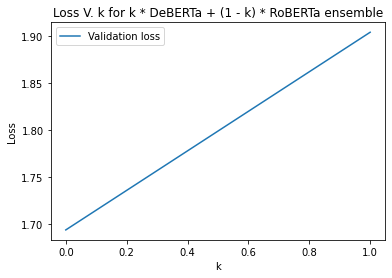

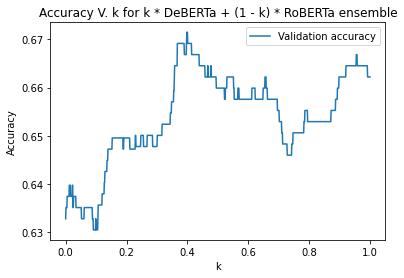

In [15]:
#plotting the training and validation loss
plt.plot(list(np.arange(0, 1.001, 0.001)), val_loss, label = 'Validation loss')
plt.title("Loss V. k for k * DeBERTa + (1 - k) * RoBERTa ensemble")
plt.xlabel("k")
plt.ylabel("Loss")
plt.legend()
plt.show()

#plotting the training and validation accuracy
plt.plot(list(np.arange(0, 1.001, 0.001)), val_acc, label = 'Validation accuracy')
plt.title("Accuracy V. k for k * DeBERTa + (1 - k) * RoBERTa ensemble")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [13]:
# Test loop
roberta_model.eval()
deberta_model.eval()

total_test_loss = 0
total_test_acc = 0

for index, (batch_roberta, batch_deberta) in enumerate(zip(test_dataloader_roberta, test_dataloader_deberta)):
    input_ids_roberta, attention_mask_roberta, labels_roberta, rel_freq_heuristic_roberta = batch_roberta
    input_ids_roberta, attention_mask_roberta, labels_roberta, rel_freq_heuristic_roberta = input_ids_roberta.to(device), attention_mask_roberta.to(device), labels_roberta.to(device), rel_freq_heuristic_roberta.to(device)

    input_ids_deberta, attention_mask_deberta, labels_deberta, rel_freq_heuristic_deberta = batch_deberta
    input_ids_deberta, attention_mask_deberta, labels_deberta, rel_freq_heuristic_deberta = input_ids_deberta.to(device), attention_mask_deberta.to(device), labels_deberta.to(device), rel_freq_heuristic_deberta.to(device)

    with torch.no_grad():
        deberta_outputs = deberta_model(input_ids_deberta, attention_mask = attention_mask_deberta, labels = labels_deberta)
        deberta_loss = deberta_outputs[0].item()
        deberta_output_data = deberta_outputs[1].detach().cpu()

        roberta_outputs = roberta_model(input_ids_roberta, attention_mask = attention_mask_roberta, labels = labels_roberta)
        roberta_loss = roberta_outputs[0].item()
        roberta_output_data = roberta_outputs[1].detach().cpu()

        total_test_loss += k * deberta_loss + (1 - k) * roberta_loss
        ensemble_outputs = k * deberta_output_data + (1 - k) * roberta_output_data
        #calculating accuracy for batch
        total_test_acc += accuracy(ensemble_outputs, labels_roberta, rel_freq_heuristic_roberta)
    
    # Delete unnecessary values to save memory
    del input_ids_roberta, attention_mask_roberta, labels_roberta, rel_freq_heuristic_roberta, input_ids_deberta, attention_mask_deberta, labels_deberta, rel_freq_heuristic_deberta, roberta_outputs, deberta_outputs, roberta_loss, deberta_loss

# Calculate average test loss
avg_test_loss = total_test_loss / len(test_dataloader_deberta)
avg_test_acc = total_test_acc / len(test_dataloader_deberta)
print(f"Test Loss: {avg_test_loss}")
print(f"Test Accuracy: {avg_test_acc}")

Test Loss: 1.729627419401098
Test Accuracy: 0.6696428571428571


In [14]:
print(val_loss)
print(val_acc)

# Save the training and validation loss and accuracy to a pickle file
with open(base_dir + 'ensemble_val_loss_acc.pickle', 'wb') as f:
    f.truncate(0)
    pickle.dump((val_loss, val_acc), f)
#close file
f.close()

[1.6941355312312092, 1.6943453729583158, 1.6945552146854221, 1.6947650564125294, 1.6949748981396355, 1.6951847398667423, 1.6953945815938491, 1.6956044233209555, 1.6958142650480623, 1.6960241067751691, 1.6962339485022757, 1.6964437902293823, 1.696653631956489, 1.6968634736835957, 1.6970733154107025, 1.697283157137809, 1.6974929988649157, 1.697702840592022, 1.6979126823191288, 1.6981225240462354, 1.6983323657733422, 1.6985422075004493, 1.6987520492275552, 1.698961890954662, 1.699171732681769, 1.6993815744088754, 1.6995914161359822, 1.6998012578630888, 1.7000110995901951, 1.7002209413173022, 1.7004307830444088, 1.7006406247715158, 1.700850466498622, 1.7010603082257287, 1.7012701499528353, 1.7014799916799417, 1.701689833407049, 1.7018996751341555, 1.702109516861262, 1.7023193585883687, 1.702529200315475, 1.7027390420425823, 1.7029488837696884, 1.703158725496795, 1.7033685672239027, 1.7035784089510086, 1.703788250678115, 1.7039980924052225, 1.7042079341323286, 1.7044177758594357, 1.70462761